# RNN 的从 $0$ 开始实现

In [1]:
import torch
from torch import nn
import d2l.torch as d2l
from torch.nn import functional as F
import math

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# train_iter 是整数 (单词映射过之后的)
# vocab 可以用整数的 index 转换成词语, 也就是一个字典 

独热编码, 指定位置为 $1$ , 其余位置全部为 $0$

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

小批量数据的形状是 (批量大小, 时间步数)

这里还做了一个转置的操作, 这样做的好处就是对于每一个时间步数, 他的每一个批量的数据都在一块儿, 方便后面访问

假设是很多行句子, 这样转置之后就非常方便的取到不同行每一列的文字

In [4]:
X = torch.arange(10).reshape((2,5)) # 2 是批量 , 5 是时间步数
F.one_hot(X.T, 28).shape # 26 个英文字母, 加上空格和 unk 总共是 28

torch.Size([5, 2, 28])

循环神经网络 : 

![1](img/1.png)

更新隐藏状态 : $h_t = \phi (W_{hh}h_{t-1}+W_{hx}x_{t-1}+b_h)$

输出 : $o_t = W_{ho}h_t+b_q$

输入 $X$ 的 $shape$ 为 $(batch\_size, num\_inputs)$ , 其他 $shape$ 的变化看上面的公式, 非常的清楚

In [5]:
def get_params(vocab_size, num_hiddens, device):
    # vocab_size 是字典里面有多少个不同的数, 也就是 28
    # num_hiddens 是隐藏单元的维度
    num_inputs = num_outputs = vocab_size
    W_xh = torch.randn(size=(num_inputs, num_hiddens), device=device) * 0.01
    W_hh = torch.randn(size=(num_hiddens, num_hiddens), device=device) * 0.01
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = torch.randn(size=(num_hiddens, num_outputs), device=device) * 0.01
    b_q = torch.zeros(num_outputs, device=device) 
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

`init_rnn_state` 在初始化时返回隐藏状态

In [6]:
def init_rnn_state(batch_size, num_hidden, device): # 为了和 LSTM 一致, 返回一个 tuple
    return (torch.zeros((batch_size, num_hidden), device=device), )

因为之前转置了, 所以这个地方 `X in inputs` 的时候就是一列数据了

`rnn` 函数定义了在一个时间步内计算隐藏状态和输出

使用 $tanh$ 函数作为激活函数, 这是一个类似 $sigmoid$ 的函数, 最大值和最小值分别是 $1,-1$

In [7]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) # mm 的 H 是前一个 H 
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,) # 拼出来是一个二维的矩阵, 列数是 vocab_size , 行数变成了批量大小乘上时间的长度 

整合在一起

In [8]:
class RNNModel:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32) # 先把 X 转化成
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状

$new\_state$ : ( $batch\_size$ , $num\_hiddens$ )

$Y$ : ( $batch\_size\ *\ num\_hiddens$ , $vocab\_size$ )

In [9]:
num_hiddens = 512
net = RNNModel(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

预测函数

In [10]:
def predict(prefix, num_preds, net, vocab, device):
    # prefix 是一个开头, 我们根据这个开头可以生成接下来的一些词
    # num_preds 是生成多少个词
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]] # outputs 一开始就是一个词(第一个), 将这个词语映射成下标然后存起来
    get_input = lambda : torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 先根据 prefix 调整隐状态
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [11]:
predict('time traveller', 10, net, vocab, d2l.try_gpu())

'time travellerttwgafzrtt'

梯度裁剪

**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**

当 $g$ 的范数超过 $\theta$ 的时候, 就会裁剪为 $\theta$

In [12]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) # list
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

训练

In [13]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    # use_random_iter 表示每个 epoch 是不是连续的, 也就是是不是打乱的, 如果不是打乱的, 那么按照顺序拼接起来就是一篇文章
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和, 词元数量 
    for X, Y in train_iter:
        if state is None or use_random_iter: # 在第一次迭代的时候随机化, 如果使用随机iter也进行随机化 
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else: # 每个 epoch 都把之前的 state 给 detach 掉, 避免计算太复杂
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else: # LSTM 从 0 实现是 tuple
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) # Y.shape : [32, 35]
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:
def train(net, train_iter, vocab, lr, num_epoch, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epoch])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size : d2l.sgd(net.params, lr, batch_size)
    for epoch in range(num_epoch):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch+1) % 10 == 0:
            print(predict('time traveller', 50, net, vocab, device))
            animator.add(epoch+1, [ppl])
    print(f'perplexity is {ppl:.1f} , speed is {speed:.1f} token per second on {str(device)}')
    print(predict('time traveller', 50, net, vocab, device))
    print(predict('traveller', 50, net, vocab, device))

time traveller for so it will be convenient to speak of himwas e


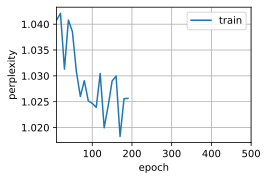

In [17]:
num_epoch, lr = 500, 1
train(net, train_iter, vocab, lr, num_epoch, d2l.try_gpu())

使用随机抽样的方法进行训练

perplexity is 1.4 , speed is 65632.5 token per second on cuda:0
time travellerit s against reason said filbycan a cube that does
travellerit s against reason said filbycan a cube that does


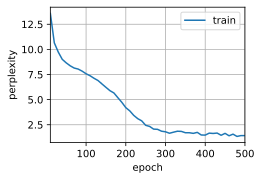

In [16]:
net = RNNModel(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train(net, train_iter, vocab, lr, num_epoch, d2l.try_gpu(), use_random_iter=True)